🎯 AIM of the Competition

The goal is to forecast the daily unit sales of thousands of products sold in various Walmart stores across the United States for the next 28 days.

More specifically:

You’re given historical sales data (d_1 to d_1913) for many products.

Each product is defined by its item_id, store_id, and category (like HOBBIES, FOODS, HOUSEHOLD).

You must predict future sales (F1–F28) for each item-store combination.

The forecasts are made for two sets:

Validation set: corresponds to days d_1914 – d_1941 (public leaderboard)

Evaluation set: corresponds to days d_1942 – d_1969 (private leaderboard)

✅ In simple words:

Predict the number of units sold for every item in every store for the next 28 days.

📊 EVALUATION CRITERIA

The predictions are evaluated using Weighted Root Mean Squared Scaled Error (WRMSSE) — a version of RMSSE that accounts for:

Scaling (to handle different sales magnitudes)

Weighting (to reflect the economic importance of items)

🧠 Explanation of Relationships

Relationship	                        Connection	                        Purpose


sales_train_* ↔ calendar.csv	        via d_1…d_1969 = date	            Map day numbers to real dates, events, SNAP indicators

sell_prices.csv ↔ calendar.csv	        via wm_yr_wk	                    Match prices to actual calendar weeks

sales_train_* ↔ sell_prices.csv	        via store_id + item_id + wm_yr_wk	Combine sales quantities with price data

sample_submission.csv ↔ sales_train_*	via id	                            Defines the exact forecast targets and structure for submission

🧭 Data Flow Summary

calendar.csv gives real-world time context.

sell_prices.csv adds economic signals (price per week).

sales_train_validation.csv and sales_train_evaluation.csv provide historical and validation sales data.

sample_submission.csv tells you how to submit your predictions for 28 future days.

🧩 PHASE 1 — Setup and Load CSVs


🧠 1. Load All Files (Notebook or Python Script)

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def find_data_dir():
    """Search upwards for 'data' or 'app/data' and return the first that exists."""
    cwd = Path.cwd()
    candidates = ["data", "app/data"]
    # direct children of cwd
    for c in candidates:
        p = cwd / c
        if p.exists() and p.is_dir():
            return p
    # walk parents
    for parent in [cwd] + list(cwd.parents):
        for c in candidates:
            p = parent / c
            if p.exists() and p.is_dir():
                return p
    raise FileNotFoundError("Could not locate a 'data' or 'app/data' directory.")

DATA_DIR = find_data_dir()
print("Using data dir:", DATA_DIR)

# Optional: list files so you’re sure we’re in the right place
print("CSV files found:", [p.name for p in DATA_DIR.glob("*.csv")])

# Load
calendar     = pd.read_csv(DATA_DIR / "calendar.csv")
sell_prices  = pd.read_csv(DATA_DIR / "sell_prices.csv", low_memory=False)
sales_val    = pd.read_csv(DATA_DIR / "sales_train_validation.csv")
sales_eval   = pd.read_csv(DATA_DIR / "sales_train_evaluation.csv")
sample_sub   = pd.read_csv(DATA_DIR / "sample_submission.csv")

print("✅ Files loaded successfully!")


Using data dir: c:\AIMinor_Module_E_Project\AI_Driven_Retail_Inventory_&_Replenishment\AIretail\data
CSV files found: ['calendar.csv', 'sales_train_evaluation.csv', 'sales_train_validation.csv', 'sample_submission.csv', 'sell_prices.csv']
✅ Files loaded successfully!


🧾 2. Quick Overview

In [5]:
# Check shapes
print("calendar:", calendar.shape)
print("sell_prices:", sell_prices.shape)
print("sales_train_validation:", sales_val.shape)
print("sales_train_evaluation:", sales_eval.shape)
print("sample_submission:", sample_sub.shape)

# Peek first few rows
calendar.head()


calendar: (1969, 14)
sell_prices: (6841121, 4)
sales_train_validation: (30490, 1919)
sales_train_evaluation: (30490, 1947)
sample_submission: (60980, 29)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,,,,,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,,,,,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,,,,,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,,,,,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,,,,,1,0,1


🧮 PHASE 2 — Basic Data Cleaning & Structure --> (preparation + merging)

1️⃣ Calendar file

In [6]:
calendar.info()
calendar.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  1969 non-null   object
 1    wm_yr_wk             1969 non-null   int64 
 2    weekday              1969 non-null   object
 3    wday                 1969 non-null   int64 
 4    month                1969 non-null   int64 
 5    year                 1969 non-null   int64 
 6    d                    1969 non-null   object
 7    event_name_1         1969 non-null   object
 8    event_type_1         1969 non-null   object
 9    event_name_2         1969 non-null   object
 10   event_type_2         1969 non-null   object
 11   snap_CA              1969 non-null   int64 
 12   snap_TX              1969 non-null   int64 
 13   snap_WI              1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
count,1969,1969.000000,1969,1969.000000,1969.000000,1969.000000,1969,1969,1969,1969,1969,1969.000000,1969.000000,1969.000000
unique,1969,NaN,7,NaN,NaN,NaN,1969,31,5,5,3,NaN,NaN,NaN
top,2011-01-29,NaN,Saturday,NaN,NaN,NaN,d_1,,,,,NaN,NaN,NaN
freq,1,NaN,282,NaN,NaN,NaN,1,1807,1807,1964,1964,NaN,NaN,NaN
mean,NaN,11347.086338,NaN,3.997461,6.325546,2013.288471,NaN,NaN,NaN,NaN,NaN,0.330117,0.330117,0.330117
std,NaN,155.277043,NaN,2.001141,3.416864,1.580198,NaN,NaN,NaN,NaN,NaN,0.470374,0.470374,0.470374
min,NaN,11101.000000,NaN,1.000000,1.000000,2011.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,11219.000000,NaN,2.000000,3.000000,2012.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,11337.000000,NaN,4.000000,6.000000,2013.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
75%,NaN,11502.000000,NaN,6.000000,9.000000,2015.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000


In [7]:
sales_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


Converting this wide format → long format (each day = one row):

In [8]:
sales_val_melted = sales_val.melt(
    id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
    var_name='d',
    value_name='sales'
)
print(sales_val_melted)

                                     id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
58327365    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
58327366    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
58327367    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
58327368    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
58327369    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  sales  
0            CA_1  

3️⃣  Merge with Calendar and Sales Price

In [9]:
def normalize_cols(df):
    # Remove non-breaking spaces, strip, collapse internal whitespace to single underscore
    df.columns = (
        df.columns
          .str.replace('\u00a0', ' ', regex=False)  # NBSP → space
          .str.strip()
          .str.replace(r'\s+', '_', regex=True)     # spaces → single underscore
    )
    return df

calendar = normalize_cols(calendar)
sell_prices = normalize_cols(sell_prices)
sales_val = normalize_cols(sales_val)

print("calendar cols:", calendar.columns.tolist())  # sanity check
print("sell_prices cols:", sell_prices.columns.tolist())
print("sales_val cols:", sales_val.columns.tolist())

# Ensure essential keys exist now
assert {'d','date','wm_yr_wk'}.issubset(calendar.columns), \
    f"calendar missing: { {'d','date','wm_yr_wk'} - set(calendar.columns) }"

# Types
calendar['date'] = pd.to_datetime(calendar['date'], errors='raise')
# (optional, but consistent)
# sell_prices['wm_yr_wk'] = sell_prices['wm_yr_wk'].astype(int)

# Melt sales to long
id_cols = ['id','item_id','dept_id','cat_id','store_id','state_id']
sales_val_melted = sales_val.melt(id_vars=id_cols, var_name='d', value_name='sales')

# Merge with calendar
sales_val_merged = sales_val_melted.merge(
    calendar[['d','date','wm_yr_wk']], on='d', how='left'
)

# Merge with prices
sales_val_merged = sales_val_merged.merge(
    sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left'
)

sales_val_merged.head()

calendar cols: ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']
sell_prices cols: ['store_id', 'item_id', 'wm_yr_wk', 'sell_price']
sales_val cols: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,NaT,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,NaT,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,NaT,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,NaT,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,NaT,NaN,NaN


<Axes: ylabel='Frequency'>

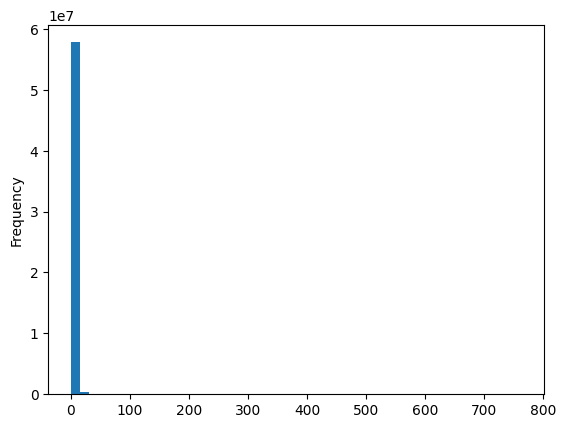

In [10]:
sales_val_merged.describe()
sales_val_merged['sales'].plot(kind='hist', bins=50)

🧩 PHASE 3 – Data Cleaning & Pre-Processing

🧼 STEP 1 — Clean calendar.csv

In [11]:
# --- Normalize column names ---
calendar.columns = (
    calendar.columns
        .str.replace('\u00a0',' ', regex=False)
        .str.strip()
        .str.replace(r'\s+', '_', regex=True)
)

# --- Convert date & check missing ---
calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')

# --- Fill event_name/type NaNs with 'None' ---
event_cols = [c for c in calendar.columns if 'event' in c]
calendar[event_cols] = calendar[event_cols].fillna('None')

# --- Replace SNAP NaN with 0 ---
snap_cols = [c for c in calendar.columns if 'snap' in c]
calendar[snap_cols] = calendar[snap_cols].fillna(0).astype(int)

# --- Drop fully duplicate rows (if any) ---
calendar = calendar.drop_duplicates()

print("Calendar cleaned ✅")
print(calendar.info())
print(calendar.isna().sum())


Calendar cleaned ✅
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int64         
 2   weekday       1969 non-null   object        
 3   wday          1969 non-null   int64         
 4   month         1969 non-null   int64         
 5   year          1969 non-null   int64         
 6   d             1969 non-null   object        
 7   event_name_1  1969 non-null   object        
 8   event_type_1  1969 non-null   object        
 9   event_name_2  1969 non-null   object        
 10  event_type_2  1969 non-null   object        
 11  snap_CA       1969 non-null   int64         
 12  snap_TX       1969 non-null   int64         
 13  snap_WI       1969 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(6)
memory usage: 215.5+ KB
Non

💰 STEP 2 — Clean sell_prices.csv

In [12]:
# --- Normalize column names ---
sell_prices.columns = (
    sell_prices.columns
        .str.replace('\u00a0',' ', regex=False)
        .str.strip()
        .str.replace(r'\s+', '_', regex=True)
)

# --- Convert wm_yr_wk numeric & sell_price float ---
sell_prices['wm_yr_wk'] = pd.to_numeric(sell_prices['wm_yr_wk'], errors='coerce')
sell_prices['sell_price'] = pd.to_numeric(sell_prices['sell_price'], errors='coerce')

# --- Drop duplicates ---
sell_prices = sell_prices.drop_duplicates()

# --- Handle missing prices: forward fill within same item-store ---
sell_prices = (
    sell_prices
    .sort_values(['store_id','item_id','wm_yr_wk'])
    .groupby(['store_id','item_id'], group_keys=False)
    .apply(lambda df: df.ffill().bfill())
)

print("Sell prices cleaned ✅")
print(sell_prices.isna().sum())


C:\Users\prana\AppData\Local\Temp\ipykernel_6140\915788674.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.ffill().bfill())


Sell prices cleaned ✅
store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64


📊 STEP 3 — Clean sales_train_* files

In [13]:
# --- Normalize column names ---
for df in [sales_val, sales_eval]:
    df.columns = (
        df.columns
          .str.replace('\u00a0',' ', regex=False)
          .str.strip()
          .str.replace(r'\s+', '_', regex=True)
    )

# --- Check numeric day columns ---
day_cols_val = [c for c in sales_val.columns if c.startswith('d_')]
day_cols_eval = [c for c in sales_eval.columns if c.startswith('d_')]

sales_val[day_cols_val] = sales_val[day_cols_val].apply(pd.to_numeric, errors='coerce')
sales_eval[day_cols_eval] = sales_eval[day_cols_eval].apply(pd.to_numeric, errors='coerce')

# --- Replace negatives or NaN with 0 (since sales can’t be negative) ---
sales_val[day_cols_val] = sales_val[day_cols_val].clip(lower=0).fillna(0)
sales_eval[day_cols_eval] = sales_eval[day_cols_eval].clip(lower=0).fillna(0)

print("Sales validation/evaluation cleaned ✅")
print("Missing values:", sales_val.isna().sum().sum(), sales_eval.isna().sum().sum())


Sales validation/evaluation cleaned ✅
Missing values: 0 0


🔍 STEP 4 — Save Clean Versions for Next Phase

In [14]:
clean_dir = Path("../app/data_cleaned")
clean_dir.mkdir(exist_ok=True)

calendar.to_csv(clean_dir / "calendar_clean.csv", index=False)
sell_prices.to_csv(clean_dir / "sell_prices_clean.csv", index=False)
sales_val.to_csv(clean_dir / "sales_train_validation_clean.csv", index=False)
sales_eval.to_csv(clean_dir / "sales_train_evaluation_clean.csv", index=False)

print("✅ Cleaned files saved in:", clean_dir)


✅ Cleaned files saved in: ..\app\data_cleaned


🧭 PHASE 4 – Exploratory Data Analysis → Forecast Modeling → Evaluation

🔍 4.1 – Exploratory Data Analysis (EDA)

Goal → discover trends, patterns, and seasonality.

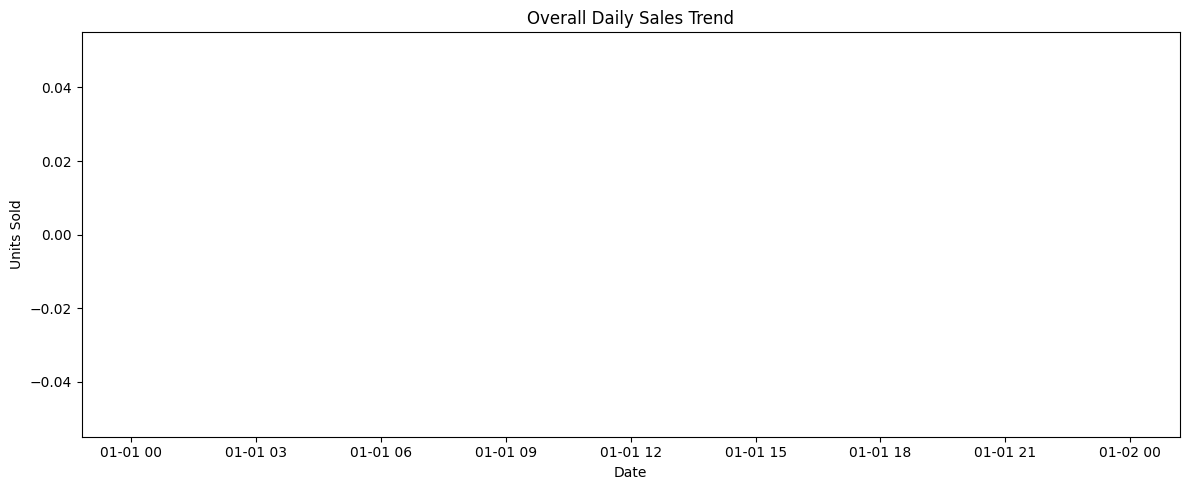

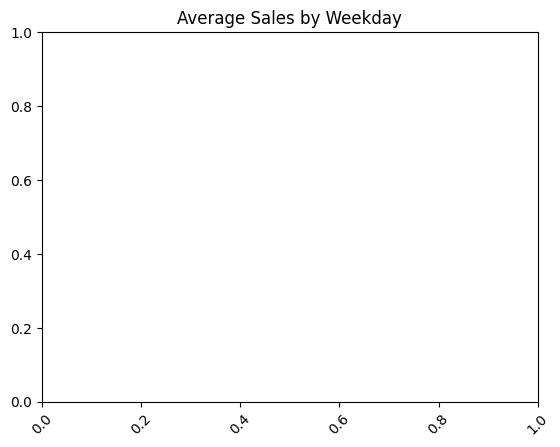

SNAP indicator distribution:
    snap_CA  snap_TX  snap_WI  size
0        0        0        0   994
1        0        0        1    65
2        0        1        0    65
3        0        1        1   195
4        1        0        0   130


In [15]:
DATA_DIR = Path("../app/data_cleaned")

calendar     = pd.read_csv(DATA_DIR / "calendar_clean.csv", parse_dates=["date"])
sell_prices  = pd.read_csv(DATA_DIR / "sell_prices_clean.csv")
sales_val    = pd.read_csv(DATA_DIR / "sales_train_validation_clean.csv")

# Melt wide → long for EDA
id_cols = ['id','item_id','dept_id','cat_id','store_id','state_id']
sales_long = sales_val.melt(id_vars=id_cols, var_name='d', value_name='sales')
calendar_cols = ['d','date','event_name_1','event_type_1','snap_CA','snap_TX','snap_WI']
sales_long = sales_long.merge(calendar[calendar_cols], on='d', how='left')

# Total daily sales
daily = sales_long.groupby('date', as_index=False)['sales'].sum()
plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['sales'])
plt.title("Overall Daily Sales Trend")
plt.xlabel("Date"); plt.ylabel("Units Sold")
plt.tight_layout(); plt.show()

# Weekly seasonality
weekly = daily.copy()
weekly['weekday'] = weekly['date'].dt.day_name()
sns.barplot(x='weekday', y='sales', data=weekly)
plt.title("Average Sales by Weekday")
plt.xticks(rotation=45)
plt.show()

# Check correlation with SNAP
snap_cols = ['snap_CA','snap_TX','snap_WI']
snap_effect = calendar.groupby(snap_cols, as_index=False).size()
print("SNAP indicator distribution:\n", snap_effect.head())

🧱 4.2 – Feature Engineering

Lag features: sales(t-1), sales(t-7) (weekly memory)

Rolling means: 7-day / 28-day

Price & promotion effects: from sell_prices_clean

Event indicators: from calendar_clean

In [16]:
# --- 0) Normalize cols everywhere (spaces, NBSP) ---
def norm_cols(df):
    return (df.rename(columns=lambda c: c.replace('\u00a0',' '))
              .rename(columns=lambda c: c.strip())
              .rename(columns=lambda c: c.replace(' ', '_')))

calendar    = norm_cols(calendar)
sell_prices = norm_cols(sell_prices)
sales_long  = norm_cols(sales_long)

# Types
calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')
sell_prices['wm_yr_wk'] = pd.to_numeric(sell_prices['wm_yr_wk'], errors='coerce')
sell_prices['sell_price'] = pd.to_numeric(sell_prices['sell_price'], errors='coerce')

# --- 1) Ensure sales_long has 'date' and attach 'wm_yr_wk' from calendar ---
# (use date join because sales_long already has 'date')
if 'wm_yr_wk' not in sales_long.columns:
    sales_long = sales_long.merge(
        calendar[['date','wm_yr_wk']], on='date', how='left'
    )

# Safety: if you only have 'd' in sales_long, use this instead:
# sales_long = sales_long.merge(calendar[['d','wm_yr_wk']], on='d', how='left')

# --- 2) Verify merge keys exist and are clean ---
for col in ['store_id','item_id','wm_yr_wk']:
    assert col in sales_long.columns, f"Missing in sales_long: {col}"
    assert col in sell_prices.columns, f"Missing in sell_prices: {col}"

# --- 3) Merge prices (now wm_yr_wk is present) ---
sales_long = sales_long.merge(
    sell_prices[['store_id','item_id','wm_yr_wk','sell_price']],
    on=['store_id','item_id','wm_yr_wk'],
    how='left',
    validate='m:1'      # each (store,item,week) should map to one price row
)

# --- 4) Build rolling/lag features (per item-store) ---
sales_long = sales_long.sort_values(['item_id','store_id','date'])
grp = sales_long.groupby(['item_id','store_id'], group_keys=False)

sales_long['lag_7']   = grp['sales'].shift(7)
sales_long['roll_7']  = grp['sales'].transform(lambda s: s.rolling(7,  min_periods=1).mean())
sales_long['roll_28'] = grp['sales'].transform(lambda s: s.rolling(28, min_periods=1).mean())

# price features (fill gaps in price within series so diff works)
sales_long['sell_price'] = grp['sell_price'].apply(lambda s: s.ffill().bfill())
sales_long['price_diff'] = grp['sell_price'].diff()

print("Done. Columns now available:",
      ['sell_price','lag_7','roll_7','roll_28','price_diff'] )


Done. Columns now available: ['sell_price', 'lag_7', 'roll_7', 'roll_28', 'price_diff']


In [17]:
print("sales_long cols:", sales_long.columns.tolist())
print("sell_prices cols:", sell_prices.columns.tolist())

sales_long cols: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'event_name_1', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI', 'wm_yr_wk', 'sell_price', 'lag_7', 'roll_7', 'roll_28', 'price_diff']
sell_prices cols: ['store_id', 'item_id', 'wm_yr_wk', 'sell_price']


⚙️ 4.3 – Forecast Modeling

Start simple → baseline → gradient boosting.

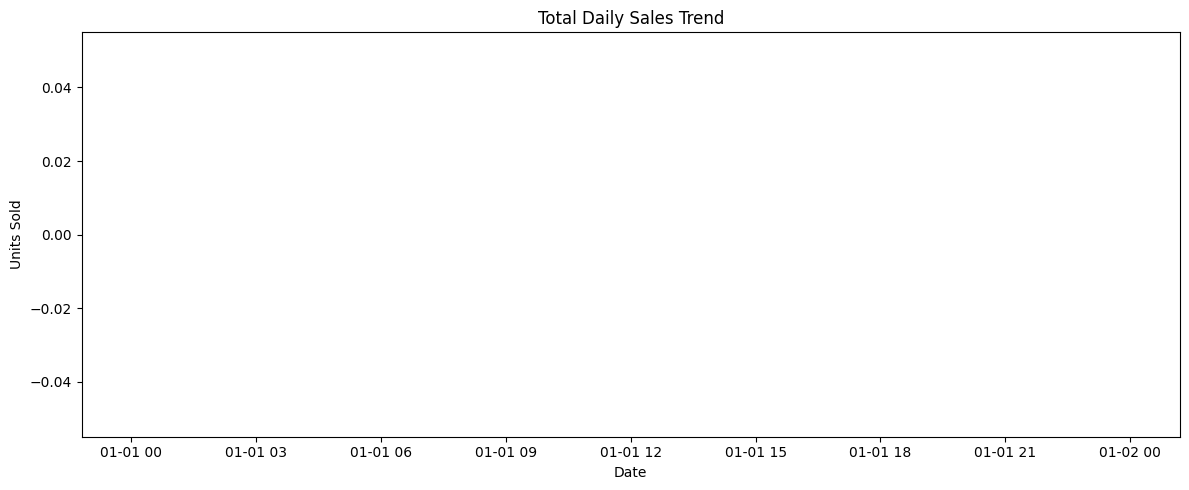

In [18]:

import pandas as pd
import matplotlib.pyplot as plt
sales_long['sales'] = pd.to_numeric(sales_long['sales'], errors='coerce')
sales_long['date'] = pd.to_datetime(sales_long['date'], errors='coerce')

daily = sales_long.groupby('date', as_index=False)['sales'].sum()
plt.figure(figsize=(12,5))
plt.plot(daily['date'], daily['sales'], color='steelblue')
plt.title("Total Daily Sales Trend")
plt.xlabel("Date"); plt.ylabel("Units Sold")
plt.tight_layout(); plt.show()